# Viga del ejemplo 4

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    | ---   | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Febrero 12, 2024  | Conversión de código de Maxima a Python |

$$
\newcommand{\dd}{\operatorname{d} \!}
$$

Utilizando la **teoría de vigas de Timoshenko-Ehrenfest**, calcule los diagramas de fuerza cortante, momento flector, ángulo de giro y deflexión vertical de la viga mostrada en la figura:

<img src="viga_4.png" width="600">

In [1]:
from sympy import init_printing, latex, DiracDelta, Piecewise, integrate, symbols, Eq, plot, piecewise_fold, solve, Interval, Rational, sets, diff, expand
from sympy.abc import x

# Para imprimir bonito
init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{latex(variable)}' + texto2)

Se define una función que hace el código más corto y legible, evitando el uso de las [funciones G de Meijerg](https://en.wikipedia.org/wiki/Meijer_G-function):

In [2]:
integre = lambda f, x : integrate(f, x, meijerg=False)

Se define la geometría de la viga y las propiedades del material:

In [3]:
L = 12              # [m]   Longitud de la viga
b = Rational(1, 10) # [m]   Ancho de la viga
h = Rational(3, 10) # [m]   Altura de la viga
E = 210_000_000     # [kPa] Módulo de elasticidad de la viga
nu = 0.3            #       Coeficiente de Poisson
G = E/(2*(1 + nu))  # [kPa] Módulo de cortante
I = (b*h*h*h)/12    # [m⁴]  Momento de inercia en z    
A = b*h             # [m²]  Área de la sección transversal
alpha = 5/6         #       Factor de corrección del esfuerzo cortante para una sección rectangular

Se definen las cargas distribuidas de acuerdo con la tabla 10.3 del `main.pdf`

In [4]:
# Caso 1: integral del momento flector
int_mflec = lambda m,a : -m*DiracDelta(x-a)

# Caso 2: carga puntual 
qpunt = lambda p,a : p*DiracDelta(x-a)

# Caso 7: carga distribuida variable 
qdist = lambda f,a,b : Piecewise((f, (a < x) & (x < b)), (0, True))

# Funcion rectangular: si x>a y x<b retorne 1 sino retorne 0   
rect = lambda a,b : Piecewise((1, (a < x) & (x < b)), (0, True))

Se especifica la carga distribuida $q(x)$. Observe que aqui no se incluye el momento de -16 kN m en $x$ = 8 m, ya que  este se tendra en cuenta cuando se planteen las ecuaciones que resuelven las constantes de integración:

In [5]:
q_sin_momento = qdist(-Rational(1,18)*x*x + Rational(4,9)*x - Rational(26,9),4,10) + qpunt(-15,6)
int_momento1  = int_mflec(27, 2)

Se resuelve la ecuación diferencial tramo por tramo:

In [6]:
# Tramo 1: de x=0m a x=4m
C1_1, C1_2, C1_3, C1_4 = symbols('C1_1 C1_2 C1_3 C1_4')
q1   = q_sin_momento*rect(0,4)   # restriccion de q al tramo 1   
Vsm1 = integre(q1, x)                    + C1_1
V1   = Vsm1 + int_momento1
M1   = integre(V1, x)                    + C1_2
t1   = integre(M1/(E*I), x)              + C1_3
v1   = integre(t1 - Vsm1/(alpha*G*A), x) + C1_4

# Tramo 2: de x=4m a x=8m
C2_1, C2_2, C2_3, C2_4 = symbols('C2_1 C2_2 C2_3 C2_4')
q2 = q_sin_momento*rect(4,8)               # restriccion de q al tramo 2   
V2 = integre(q2, x)                      + C2_1
M2 = integre(V2, x)                      + C2_2
t2 = integre(M2/(E*I), x)                + C2_3
v2 = integre(t2 - V2/(alpha*G*A), x)     + C2_4

# Tramo 3: de x=8m a x=12m
C3_1, C3_2, C3_3, C3_4 = symbols('C3_1 C3_2 C3_3 C3_4')
q3 = q_sin_momento*rect(8,12)              # restriccion de q al tramo 3   
V3 = integre(q3, x)                      + C3_1
M3 = integre(V3, x)                      + C3_2
t3 = integre(M3/(E*I), x)                + C3_3
v3 = integre(t3 - V3/(alpha*G*A), x)     + C3_4

Se encuentran las constantes de integración que satisfacen las condiciones de frontera:

In [7]:
sol = solve([ 
      Eq(v1.subs(x,0), 0),            # despl vertical en apoyo en x=0 es 0
      Eq(M1.subs(x,0), 0),            # momento flector en x=0 es 0
        
      Eq(v1.subs(x,4), v2.subs(x,4)), # continuidad en despl vertical en x=4
      Eq(V1.subs(x,4), V2.subs(x,4)), # continuidad en cortante en x=4
      Eq(M1.subs(x,4), 0),            # momento flector en x=4 es 0 (rotula)
      Eq(M2.subs(x,4), 0),            # momento flector en x=4 es 0 (rotula)
        
      Eq(v2.subs(x,8), 0),            # despl vertical en apoyo en x=8 es 0
      Eq(v3.subs(x,8), 0),            # despl vertical en apoyo en x=8 es 0
      Eq(t2.subs(x,8), t3.subs(x,8)), # continuidad en theta en x=8
      Eq(M3.subs(x,8), M2.subs(x,8) + 16),  # continuidad en momento en x=8
      # note que en la ecuacion anterior se incluyo la acción del 
      # momento flector ubicado en x=8m
             
      Eq(v3.subs(x,12), 0),           # desplazamiento vertical en x=12 es 0
      Eq(M3.subs(x,12), 0)            # momento flector en x=12 es 0
],    
[ 
    C1_1, C1_2, C1_3, C1_4,
    C2_1, C2_2, C2_3, C2_4,
    C3_1, C3_2, C3_3, C3_4 
])

Se fusionan las fórmulas y se reemplaza el valor de las constantes de integración:

In [8]:
V = (V1*rect(0,4) + V2*rect(4,8) + V3*rect(8,12)).subs(sol)
M = (M1*rect(0,4) + M2*rect(4,8) + M3*rect(8,12)).subs(sol)
t = (t1*rect(0,4) + t2*rect(4,8) + t3*rect(8,12)).subs(sol)
v = (v1*rect(0,4) + v2*rect(4,8) + v3*rect(8,12)).subs(sol)

Se simplifica lo calculado por sympy:

In [9]:
def simplificar(VMtv, fracciones=True):
    # rewrite(Piecewise) escribe la función como una por partes
    # as_expr_set_pairs() la expresa como una lista de tuplas
    # la tupla tiene dos elementos (función, dominio de validez)
    var = piecewise_fold(VMtv.rewrite(Piecewise)).as_expr_set_pairs(Interval(0, L))
    tmp = []
    
    # ciclo for sobre cada elemento de la tupla
    for fun, dominio in var:
        # si el dominio es un intervalo o una unión de intervalos
        if isinstance(dominio, sets.sets.Interval | sets.sets.Union):
            if fracciones:
                # intente expresar cualquier número como un fraccionario
                tmp.append((fun.nsimplify(), dominio.as_relational(x)))
            else:
                # intente expresar cualquier fraccionario como un flotante
                tmp.append((fun.evalf(),     dominio.as_relational(x)))
            # as_relational() escribe el dominio como desigualdades y expresiones lógicas

    # exprese la lista de tuplas como una función definida por partes
    return Piecewise(*tmp)

In [10]:
%%time
V = simplificar(V)

CPU times: user 3min 14s, sys: 228 ms, total: 3min 14s
Wall time: 3min 14s


In [11]:
%%time
M = simplificar(M)

CPU times: user 52.1 s, sys: 52 ms, total: 52.2 s
Wall time: 52.2 s


In [12]:
%%time
t = simplificar(t, fracciones=False)

CPU times: user 44.5 s, sys: 76 ms, total: 44.6 s
Wall time: 45.9 s


In [13]:
%%time
v = simplificar(v, fracciones=False)

CPU times: user 42.4 s, sys: 40 ms, total: 42.4 s
Wall time: 42.4 s


In [14]:
dvdx = diff(v,x)

### Se imprimen los resultados

In [15]:
imprimir("V(x) = ", V)

<IPython.core.display.Math object>

In [16]:
imprimir("M(x) = ", M)

<IPython.core.display.Math object>

In [17]:
imprimir(r"\theta(x) = ", t)

<IPython.core.display.Math object>

In [18]:
imprimir("v(x) = ", v)

<IPython.core.display.Math object>

In [19]:
imprimir(r"\frac{\dd v(x)}{\dd x} = ", dvdx)

<IPython.core.display.Math object>

### Se grafican los resultados 

In [20]:
x_xmin_xmax = (x, 0+0.001, L-0.001)

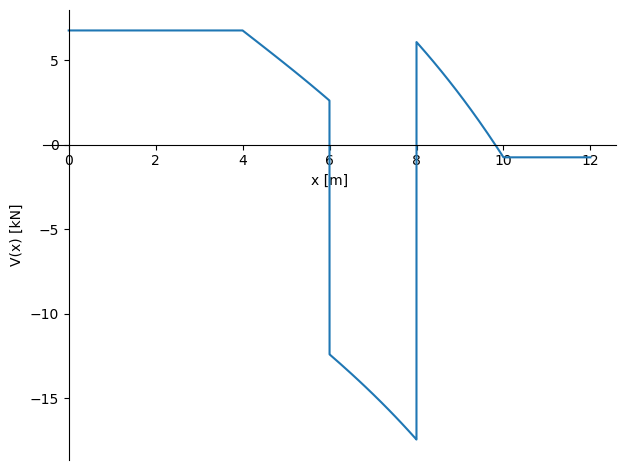

In [21]:
plot(V, x_xmin_xmax, xlabel='x [m]', ylabel='V(x) [kN]')

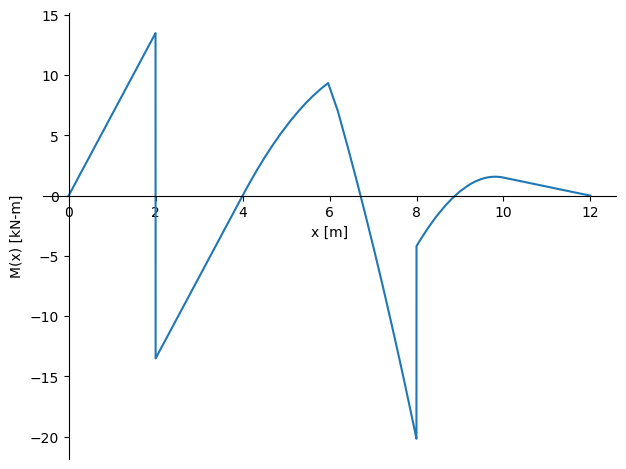

In [22]:
plot(M, x_xmin_xmax, xlabel='x [m]', ylabel='M(x) [kN-m]')

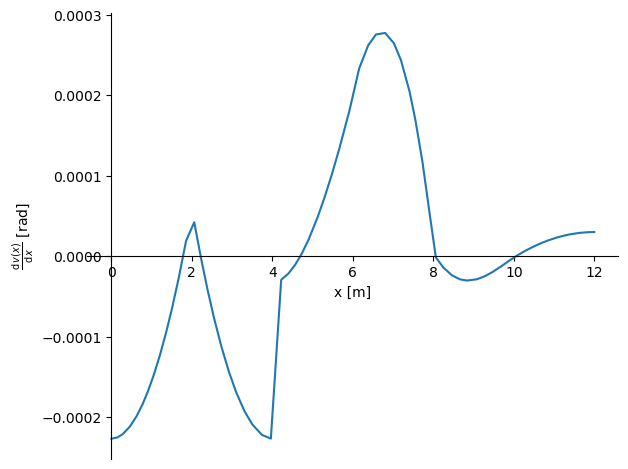

In [23]:
plot(dvdx, x_xmin_xmax, xlabel='x [m]', ylabel=r'$\frac{\operatorname{d} v(x)}{\operatorname{d} x}$ [rad]')

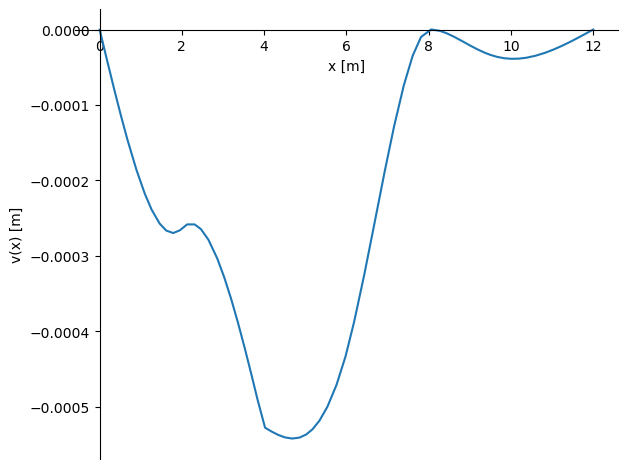

In [24]:
plot(v, x_xmin_xmax, xlabel='x [m]', ylabel='v(x) [m]')

### Se calculan las reacciones en la viga 

In [25]:
print(f"Fy(x= 0) = {float((V1+10).subs(sol).subs(x,  0))} kN")  # reacción en x=0

Fy(x= 0) = 16.75 kN


In [26]:
print(f"Fy(x= 8) = {float((V3-V2).subs(sol).subs(x,  8))} kN")  # reacción en x=8

Fy(x= 8) = 23.5 kN


In [27]:
print(f"Fy(x=12) = {float(    -V3.subs(sol).subs(x, 12))} kN")  # reacción en x=12

Fy(x=12) = 0.75 kN
